## Dataset
We need obtain Bitcoin prices from coinmarketcap.com. For now, we only consider Bitcoin, but it wouldn't be hard to add the other coins.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import datetime
import time
import sys
from PIL import Image
import io

# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
# look at the first few rows
bitcoin_market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap
0,2019-01-26,3599.72,3654.93,3593.35,3602.46,5098183235,63054898963
1,2019-01-25,3607.39,3612.93,3575.60,3599.77,5265847539,63000985908
2,2019-01-24,3584.50,3616.09,3569.09,3600.87,5262869046,63014066012
3,2019-01-23,3605.56,3623.07,3565.31,3585.12,5433755649,62731361272
4,2019-01-22,3575.08,3620.75,3539.72,3604.58,5313623556,63065139424


In [2]:
# getting the Bitcoin logos
if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

## Training, Test
1.Split training set and test set.  
2.Add some features to dataset.  
3.Create LSTM model for prediction.  

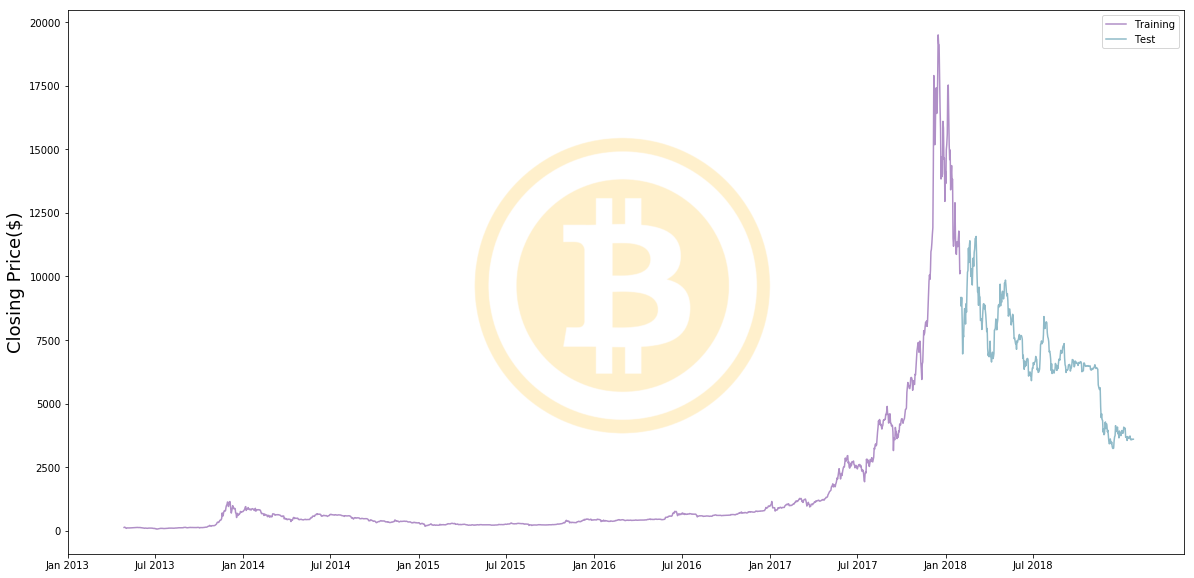

In [3]:
# Split dataset

split_date = '2018-02-01'
plt.figure(figsize=(20,10))
plt.plot(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['bt_Close'],
         color='#B08FC7', label='Training')
plt.plot(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]['bt_Close'],
         color='#8FBAC8', label='Test')
plt.ylabel('Closing Price($)', fontsize=18)
plt.xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]], [datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
plt.figimage(bitcoin_im, 300,50,zorder=2,alpha=.2)
plt.legend(loc='best')
plt.show()

In [4]:
# Add "close_off_high" and "volatility"
# Close_off_high: { 2*(bt_high - bt_low) / (bt_high - bt_low) } -1
# Volatility: (bt_high - bt_low) / bt_open

coins = 'bt_'
kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
market_info = bitcoin_market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,bt_close_off_high,bt_volatility
0,2019-01-26,3599.72,3654.93,3593.35,3602.46,5098183235,63054898963,0.704125,0.017107
1,2019-01-25,3607.39,3612.93,3575.60,3599.77,5265847539,63000985908,-0.294937,0.010348
2,2019-01-24,3584.50,3616.09,3569.09,3600.87,5262869046,63014066012,-0.352340,0.013112
3,2019-01-23,3605.56,3623.07,3565.31,3585.12,5433755649,62731361272,0.314058,0.016020
4,2019-01-22,3575.08,3620.75,3539.72,3604.58,5313623556,63065139424,-0.600889,0.022665


In [5]:
# Remove some features 

model_data = market_info[['Date']+['bt_'+metric for metric in ['Close','Volume','close_off_high','volatility']]]

# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
2099,2013-04-28,134.21,0,-0.087629,0.028677
2098,2013-04-29,144.54,0,-0.562639,0.100342
2097,2013-04-30,139.00,0,0.231366,0.089444
2096,2013-05-01,116.99,0,0.423687,0.231439
2095,2013-05-02,105.21,0,0.223890,0.286303


In [6]:
# we don't need the date columns anymore 
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]

training_set = training_set[training_set['bt_Volume']!=0]
#test_set['bt_Volume'][test_set['bt_Volume']==0] = 1.0e-10
#print(training_set['bt_Close'].size)
training_set.head()
#test_set.head()
#print(training_set)

training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

window_len = 10
norm_cols = ['bt_'+metric  for metric in ['Close','Volume']]
#print(norm_cols)

## LSTM model (keras)

In [7]:
# Create LSTM model by keras

LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1
LSTM_training_inputs[0]

print(len(LSTM_training_inputs))

1487


In [8]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_Close'][window_len:].values/test_set['bt_Close'][:-window_len].values)-1
LSTM_test_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
359,0.000000,0.000000,0.514724,0.144229
358,-0.037052,0.277878,-0.537030,0.147205
357,0.000477,-0.270660,-0.566049,0.133202
356,-0.097435,-0.289761,0.622920,0.142076
355,-0.241564,-0.067686,0.753022,0.194444
354,-0.154466,0.405687,-0.892701,0.255602
353,-0.168937,-0.079334,0.395577,0.164054
352,-0.098680,-0.061515,-0.363282,0.120572
351,-0.047277,-0.318752,-1.000000,0.103033
350,-0.059826,-0.218732,0.210645,0.094848


In [9]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
# convert [list] to [array]
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
print(type(LSTM_training_inputs))
LSTM_training_inputs = np.array(LSTM_training_inputs)
print(type(LSTM_training_inputs))
print(LSTM_training_inputs.shape)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

print(LSTM_test_inputs.shape)

print(LSTM_test_inputs)

<class 'list'>
<class 'numpy.ndarray'>
(1487, 10, 4)
(350, 10, 4)
[[[ 0.00000000e+00  0.00000000e+00  5.14723810e-01  1.44229435e-01]
  [-3.70523437e-02  2.77878099e-01 -5.37030294e-01  1.47205074e-01]
  [ 4.76525919e-04 -2.70659904e-01 -5.66049257e-01  1.33201990e-01]
  ...
  [-9.86801213e-02 -6.15147455e-02 -3.63281971e-01  1.20571731e-01]
  [-4.72774777e-02 -3.18752142e-01 -1.00000000e+00  1.03032699e-01]
  [-5.98263570e-02 -2.18732062e-01  2.10644678e-01  9.48477537e-02]]

 [[ 0.00000000e+00  0.00000000e+00 -5.37030294e-01  1.47205074e-01]
  [ 3.89729072e-02 -4.29256909e-01 -5.66049257e-01  1.33201990e-01]
  [-6.27058857e-02 -4.44204796e-01  6.22920262e-01  1.42076354e-01]
  ...
  [-1.06185771e-02 -4.66891358e-01 -1.00000000e+00  1.03032699e-01]
  [-2.36503128e-02 -3.88620919e-01  2.10644678e-01  9.48477537e-02]
  [-7.93567930e-02 -5.18956701e-01  4.19383093e-01  7.95055321e-02]]

 [[ 0.00000000e+00  0.00000000e+00 -5.66049257e-01  1.33201990e-01]
  [-9.78647202e-02 -2.61902194e-02

In [10]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [11]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1
# train model on data
history = bt_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 12s - loss: 0.0578
Epoch 2/50
 - 12s - loss: 0.0401
Epoch 3/50
 - 12s - loss: 0.0352
Epoch 4/50
 - 12s - loss: 0.0337
Epoch 5/50
 - 12s - loss: 0.0316
Epoch 6/50
 - 12s - loss: 0.0308
Epoch 7/50
 - 12s - loss: 0.0309
Epoch 8/50
 - 12s - loss: 0.0309
Epoch 9/50
 - 12s - loss: 0.0309
Epoch 10/50
 - 12s - loss: 0.0305
Epoch 11/50
 - 12s - loss: 0.0306
Epoch 12/50
 - 12s - loss: 0.0299
Epoch 13/50
 - 12s - loss: 0.0297
Epoch 14/50
 - 12s - loss: 0.0299
Epoch 15/50
 - 12s - loss: 0.0295
Epoch 16/50
 - 12s - loss: 0.0294
Epoch 17/50
 - 12s - loss: 0.0287
Epoch 18/50
 - 12s - loss: 0.0304
Epoch 19/50
 - 12s - loss: 0.0293
Epoch 20/50
 - 12s - loss: 0.0304
Epoch 21/50
 - 12s - loss: 0.0288
Epoch 22/50
 - 12s - loss: 0.0293
Epoch 23/50
 - 12s - loss: 0.0290
Epoch 24/50
 - 12s - loss: 0.0287
Epoch 25/50
 - 12s - loss: 0.0289
Epoch 26/50
 - 12s - loss: 0.0297
Epoch 27/50
 - 12s - loss: 0.0295
Epoch 28/50
 - 12s - loss: 0.0293
Epoch 29/50
 - 12s - loss: 0.0287
Epoch 30/50
 - 12s - lo

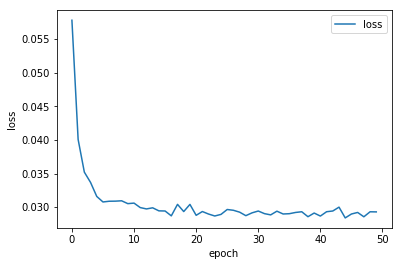

In [12]:
plt.plot(history.history["loss"], label="loss", ls="-")
#plt.plot(bt_history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

## Training dataset

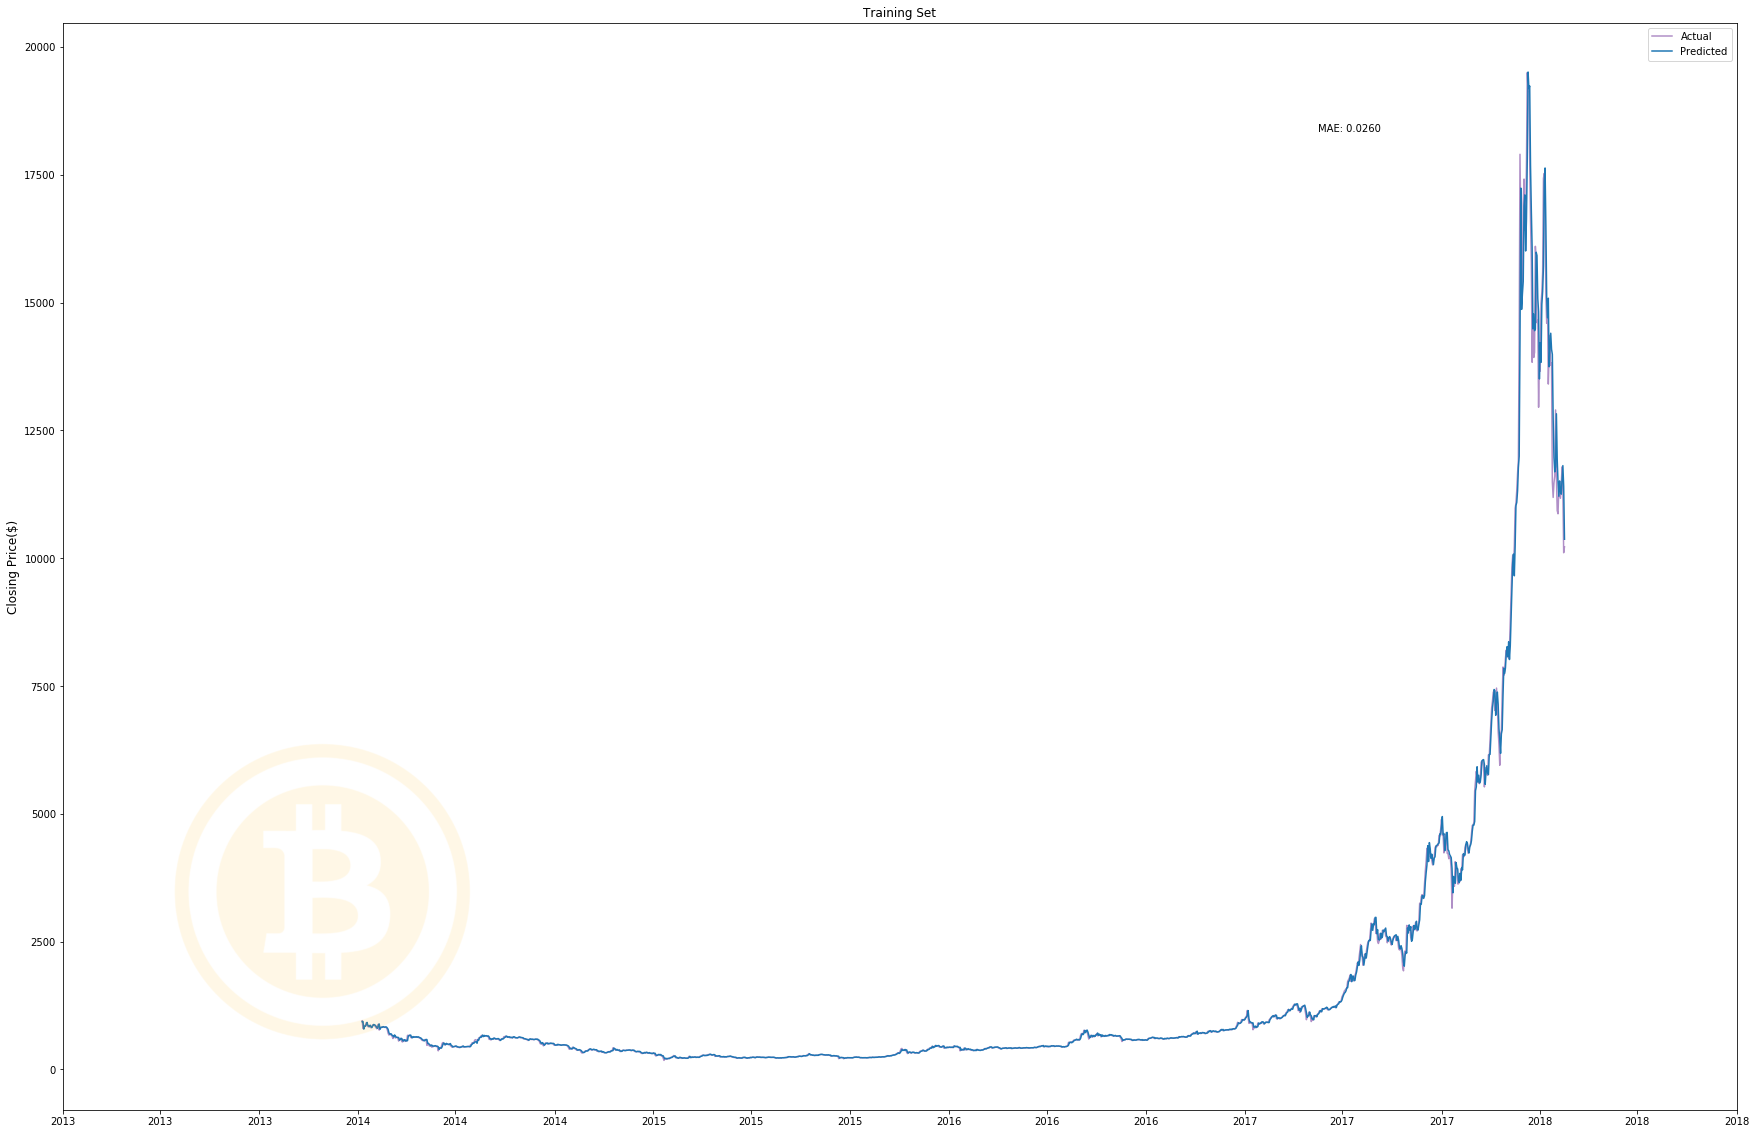

In [13]:
split_date = '2018-02-01'
start_date = '2013-12-26'
model_data = model_data[model_data['Date'] > start_date]

plt.figure(figsize=(30,20))
plt.plot(model_data[model_data['Date'] < split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], color='#B08FC7', label='Actual')
plt.plot(model_data[model_data['Date'] < split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1)*training_set['bt_Close'].values[:-window_len])[0],
         label='Predicted')
plt.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
plt.title('Training Set')
plt.ylabel('Closing Price($)', fontsize=12)
plt.xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
plt.figimage(bitcoin_im, zorder=3,alpha=.1)
plt.legend(loc='best')
plt.show()

## Test dataset

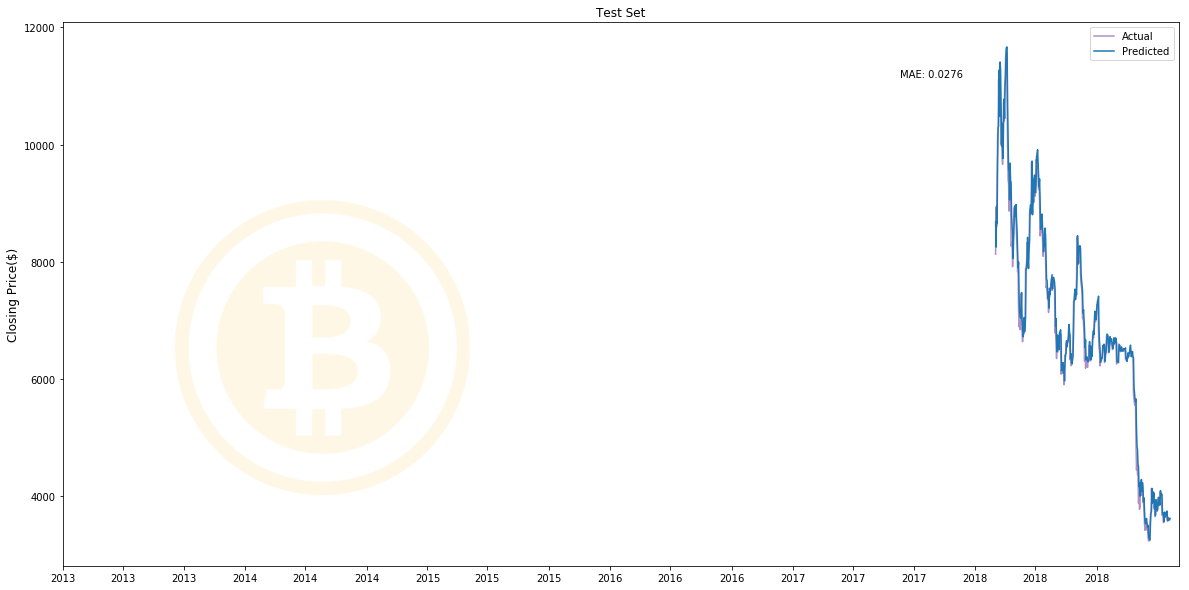

In [14]:
plt.figure(figsize=(20,10))
plt.plot(model_data[model_data['Date'] >= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], color='#B08FC7', label='Actual')
plt.plot(model_data[model_data['Date'] >= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0],
         label='Predicted')
plt.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
plt.title('Test Set')
plt.ylabel('Closing Price($)', fontsize=12)
plt.xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
plt.figimage(bitcoin_im, zorder=3,alpha=.1)
plt.legend(loc='best')
plt.show()